## Import packages

In [2]:
from cartopy import config
import cartopy
import cartopy.crs as ccrs
import cmocean
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import ttest_ind 
import xarray as xr

## Identifying co-occurring events

In [3]:
lat = -23.25
lon = 113.5

In [4]:
mhw = xr.open_dataarray('/g/data/e14/cp3790/Charuni/Tasmania/aus-ocean-sev-2.nc').sel(latitude=lat, longitude=lon, method='nearest')
thw = xr.open_dataarray('/g/data/e14/cp3790/Charuni/Tasmania/aus-coastal-sev.nc').sel(latitude=lat, longitude=lon, method='nearest')

In [5]:
thw_ = xr.where(thw>1, 1, 0)
mhw_ = xr.where(mhw>1, 1, 0)
add = thw_ + mhw_
co = xr.where(add==2, 1, 0)

## MSLP anomalies

In [6]:
ds = xr.open_dataset('/g/data/e14/cp3790/Charuni/Heatwaves/mslp_anom.nc')
mslp_anom = ds.mslp_anomaly 

In [7]:
composite_co = mslp_anom.where((thw>1) & (mhw>1), drop=True) #co-occurring events 
composite_thw = mslp_anom.where((thw>1) & (co==0), drop=True) #non co-occurring THW events

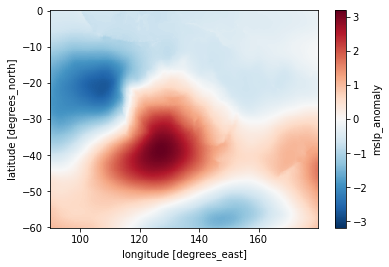

In [12]:
composite_co.mean(dim='time').plot()

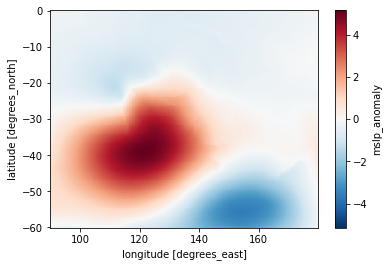

In [13]:
composite_thw.mean(dim='time').plot()

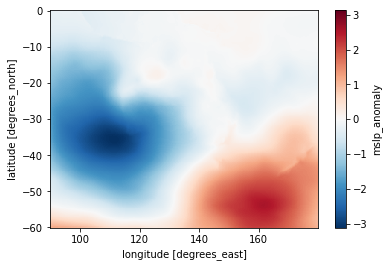

In [14]:
(composite_co.mean(dim='time') - composite_thw.mean(dim='time')).plot()

Plotting the difference between composite means 

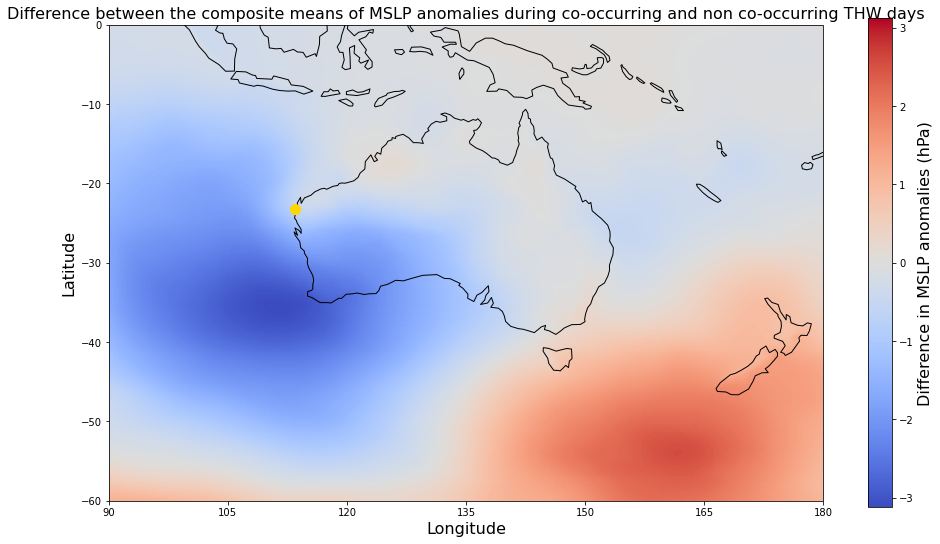

In [17]:
fig, ax = plt.subplots(figsize=(16,9))    
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xticks([90, 105, 120, 135, 150, 165, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-60, -50, -40, -30, -20, -10, 0], crs=ccrs.PlateCarree())
ploteo=(composite_co.mean(dim='time') - composite_thw.mean(dim='time')).plot(
            cmap=plt.cm.get_cmap('coolwarm'), # Specify the colourmap of interest and also the number of discrete levels. I have 5, corresponding to the number of MHW severity categories. See https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html for example  
        )


ax.coastlines()
ax.set_extent([90, 180, -60, 0],crs=ccrs.PlateCarree())
ploteo.colorbar.ax.set_ylabel('Difference in MSLP anomalies (hPa)',fontsize=16)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Difference between the composite means of MSLP anomalies during co-occurring and non co-occurring THW days', fontsize=16)
plt.plot(113.5, -23.25,  markersize=10, marker='o', color='gold')
plt.show()


T test to determine the significance of difference between the composite means 

In [18]:
# run the Welch's T-Test
r = stats.ttest_ind(composite_co, composite_thw, axis=0, equal_var=False)

# Convert the p-values into a dataarray:
da = xr.DataArray(r[1], dims=('latitude', 'longitude'), coords={
    'latitude': composite_co['latitude'],
    'longitude': composite_co['longitude']
})